In [1]:
import os
import glob

import numpy as np
import cv2
from PIL import Image
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import albumentations as A
from albumentations import HorizontalFlip, VerticalFlip, Rotate

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

/Users/dhruval/miniforge3/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
images = sorted(glob.glob('/Users/dhruval/Desktop/Applicative/GeoAI/WATER/Water Bodies Dataset/Images/*'))
masks = sorted(glob.glob('/Users/dhruval/Desktop/Applicative/GeoAI/WATER/Water Bodies Dataset/Masks/*'))

In [4]:
image = Image.open(images[0])
mask = Image.open(masks[0]).convert('L')

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Water Body (Original Image)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap = 'gray')
plt.title("Water Body (Mask)")
plt.axis('off')

plt.show()

IndexError: list index out of range

In [5]:
HEIGHT, WIDTH = (512, 512)

image_array, mask_array = np.array(image), np.array(mask)
transform = A.Compose([A.Resize(HEIGHT, WIDTH), A.HorizontalFlip()])

transformed = transform(image = image_array, mask = mask_array)
transformed_image = transformed['image']
transformed_mask = transformed['mask']

image_tensor = np.transpose(transformed_image, (2, 0, 1))
image_tensor = image_tensor / 255.0
image_tensor = torch.tensor(image_tensor, dtype = torch.float32)

mask_tensor = np.expand_dims(transformed_mask, axis = 0)
mask_tensor = mask_tensor / 255.0
mask_tensor = torch.tensor(mask_tensor, dtype = torch.float32)

image_tensor.shape, mask_tensor.shape

NameError: name 'image' is not defined

In [5]:
class ImageMaskLoader(Dataset):
    def __init__(self, images, masks, height = HEIGHT, width = WIDTH):
        super().__init__()
        self.images = images
        self.masks = masks
        self.len = len(images)
        self.transform = A.Compose([A.Resize(height, width), A.HorizontalFlip()])
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]
        
        image = Image.open(image_path)
        mask = Image.open(mask_path).convert('L')
        
        image_array, mask_array = np.array(image), np.array(mask)
        transformed = self.transform(image = image_array, mask = mask_array)
        transformed_image = transformed['image']
        transformed_mask = transformed['mask']
        
        image_tensor = np.transpose(transformed_image, (2, 0, 1))
        image_tensor = image_tensor / 255.0
        image_tensor = torch.tensor(image_tensor, dtype = torch.float32)
        
        mask_tensor = np.expand_dims(transformed_mask, axis = 0)
        mask_tensor = mask_tensor / 255.0
        mask_tensor = torch.tensor(mask_tensor, dtype = torch.float32)
        
        return image_tensor, mask_tensor
        
    def __len__(self):
        return self.len

In [6]:
images_train, images_val, masks_train, masks_val = train_test_split(images, masks, test_size = 0.2, random_state = 42)

train_dataset = ImageMaskLoader(images_train, masks_train)
val_dataset = ImageMaskLoader(images_val, masks_val)

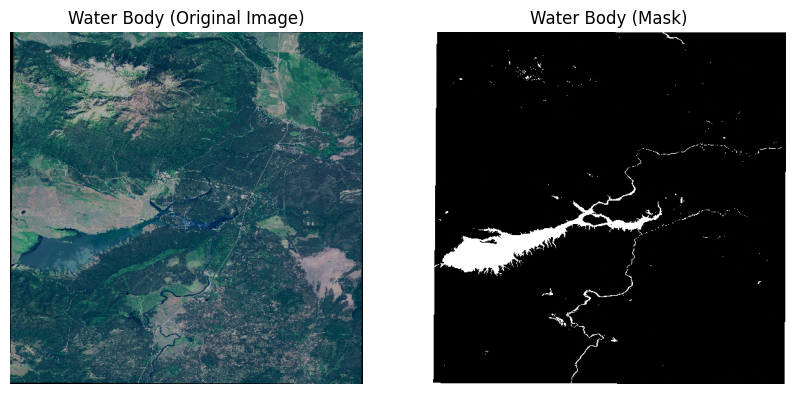

In [7]:
image, mask = train_dataset[0]
image = np.transpose(image, (1, 2, 0))

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(image.numpy()))
plt.title("Water Body (Original Image)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(mask.numpy()), cmap = 'gray')
plt.title("Water Body (Mask)")
plt.axis('off')

plt.show()

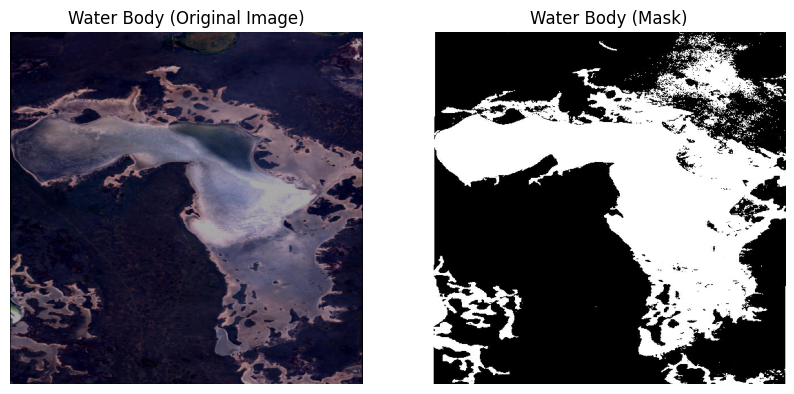

In [8]:
image, mask = val_dataset[0]
image = np.transpose(image, (1, 2, 0))

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(image.numpy()))
plt.title("Water Body (Original Image)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(mask.numpy()), cmap = 'gray')
plt.title("Water Body (Mask)")
plt.axis('off')

plt.show()

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

EPOCHS = 5
BATCH_SIZE = 16
LEARNING_RATE = 0.001

RATIO = 0.5
SAMPLE_NUM = 2

ENCODER = 'resnet50'
WEIGHTS = 'imagenet'

In [10]:
train_loader = DataLoader(
        dataset = train_dataset,
        batch_size = BATCH_SIZE,
        shuffle = True,
        num_workers=0,
)

val_loader = DataLoader(
        dataset = val_dataset,
        batch_size = BATCH_SIZE,
        shuffle = False,
        num_workers = 0,
)

In [11]:
class SegmentationModel(nn.Module):
    def __init__(self, encoder = ENCODER, weights = WEIGHTS, in_channels = 3, classes = 1):
        super(SegmentationModel,self).__init__()
        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = in_channels,
            classes = classes,
            activation = None
        )
        
    def forward(self, images,masks = None):
        logits = self.arc(images)

        if masks is not None:
            loss1 = DiceLoss(mode = 'binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            total_loss = loss1 + loss2
            return logits, loss1, loss2
            
        return logits

In [12]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

In [13]:
def train_segmentation_model(data_loader, model, optimizer, device = DEVICE):
    model.train()
    total_dice_loss = 0.0
    total_bce_loss = 0.0

    for input_images, target_masks in tqdm(data_loader):
        input_images = input_images.to(device, dtype = torch.float32)
        target_masks = target_masks.to(device, dtype = torch.float32)

        optimizer.zero_grad()

        predicted_logits, dice_loss, bce_loss = model(input_images, target_masks)

        dice_loss.backward(retain_graph = True)
        bce_loss.backward()

        optimizer.step()

        total_dice_loss += dice_loss.item()
        total_bce_loss += bce_loss.item()

    average_dice_loss = total_dice_loss / len(data_loader)
    average_bce_loss = total_bce_loss / len(data_loader)

    return average_dice_loss, average_bce_loss

def evaluate_segmentation_model(data_loader, model, device = DEVICE, ratio = RATIO, sample_num = SAMPLE_NUM):
    model.eval()
    total_dice_loss = 0.0
    total_bce_loss = 0.0

    with torch.no_grad():
        for input_images, target_masks in tqdm(data_loader):
            input_images = input_images.to(device, dtype = torch.float32)
            target_masks = target_masks.to(device, dtype = torch.float32)

            predicted_logits, dice_loss, bce_loss = model(input_images, target_masks)

            total_dice_loss += dice_loss.item()
            total_bce_loss += bce_loss.item()

        for i in range(1):
            image, mask = next(iter(data_loader))
            image = image[sample_num]
            mask = mask[sample_num]

            predicted_mask_logits = model(image.to(device, dtype = torch.float32).unsqueeze(0))
            predicted_mask = torch.sigmoid(predicted_mask_logits)
            predicted_mask = (predicted_mask > ratio) * 1.0

            image = np.transpose(image, (1, 2, 0))
            mask = mask.squeeze(0)
            predicted_mask = np.transpose(predicted_mask.detach().cpu().squeeze(0), (1, 2, 0))
            
            plt.figure(figsize = (15, 5))
            
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Water Body (Original Image)")
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.imshow(mask, cmap = 'gray')
            plt.title("Water Body (Mask)")
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.imshow(predicted_mask)
            plt.title("Water Body (Generated Mask)")
            plt.show()

    average_dice_loss = total_dice_loss / len(data_loader)
    average_bce_loss = total_bce_loss / len(data_loader)

    return average_dice_loss, average_bce_loss

optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum = 0.9)

In [14]:
print(ImageMaskLoader)
print(ImageMaskLoader.__module__)


<class '__main__.ImageMaskLoader'>
__main__



Epoch 1/5


100%|██████████| 36/36 [13:13<00:00, 22.04s/it]


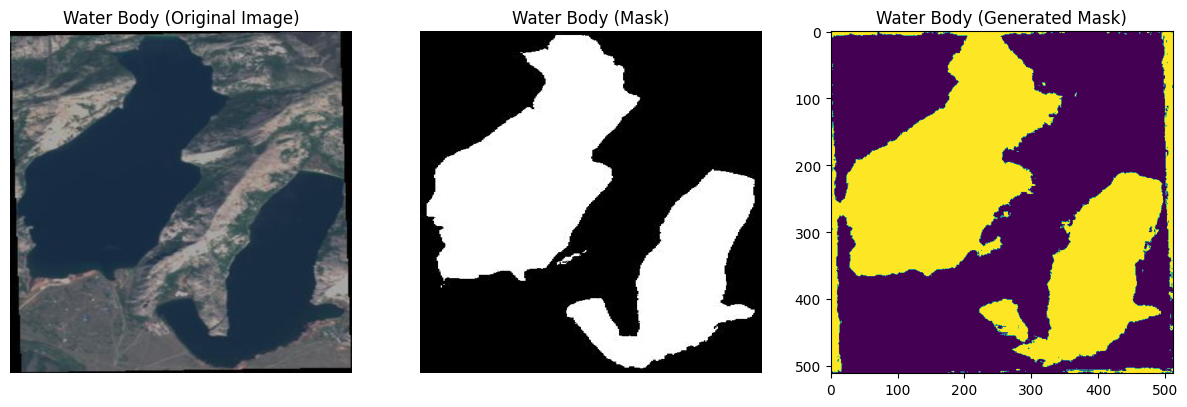

Training Losses -> Dice: 0.37861, BCE: 0.43645
Validation Losses -> Dice: 0.28431, BCE: 0.33383
Model improved and saved to /Users/dhruval/Desktop/GeoAI/WATER/modelPerformance/resnet50/model_0.28431dice.pt

Epoch 2/5


100%|██████████| 36/36 [13:07<00:00, 21.88s/it]


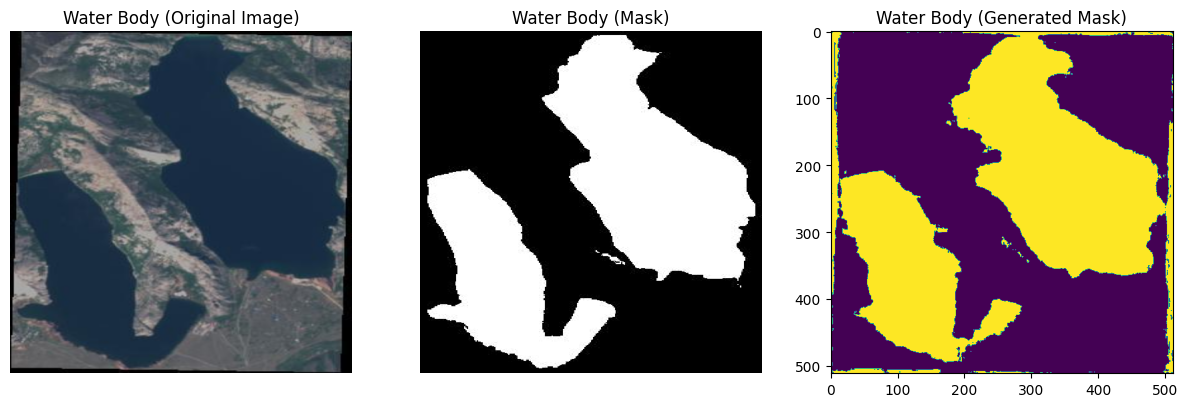

Training Losses -> Dice: 0.25753, BCE: 0.34015
Validation Losses -> Dice: 0.25966, BCE: 0.30963
Model improved and saved to /Users/dhruval/Desktop/GeoAI/WATER/modelPerformance/resnet50/model_0.25966dice.pt

Epoch 3/5


100%|██████████| 36/36 [13:11<00:00, 21.98s/it]


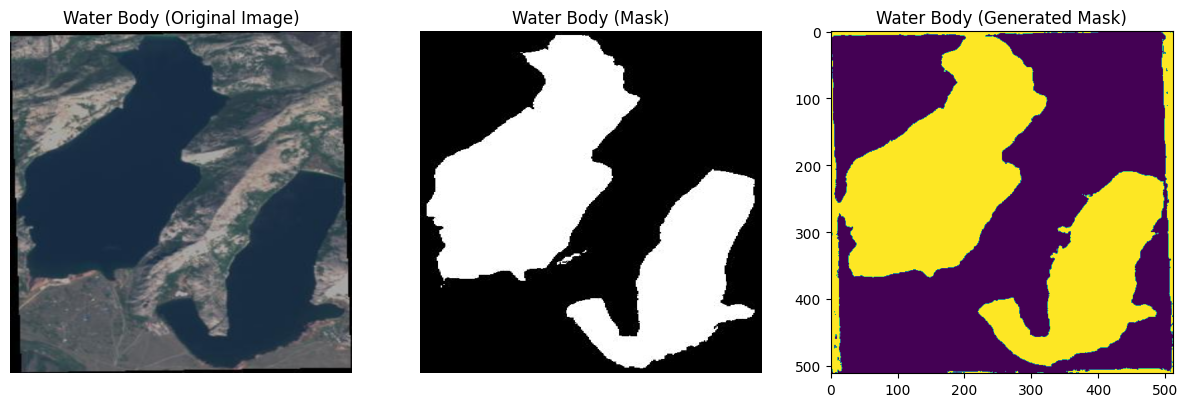

Training Losses -> Dice: 0.23772, BCE: 0.31931
Validation Losses -> Dice: 0.24244, BCE: 0.30042
Model improved and saved to /Users/dhruval/Desktop/GeoAI/WATER/modelPerformance/resnet50/model_0.24244dice.pt

Epoch 4/5


100%|██████████| 36/36 [13:37<00:00, 22.71s/it]


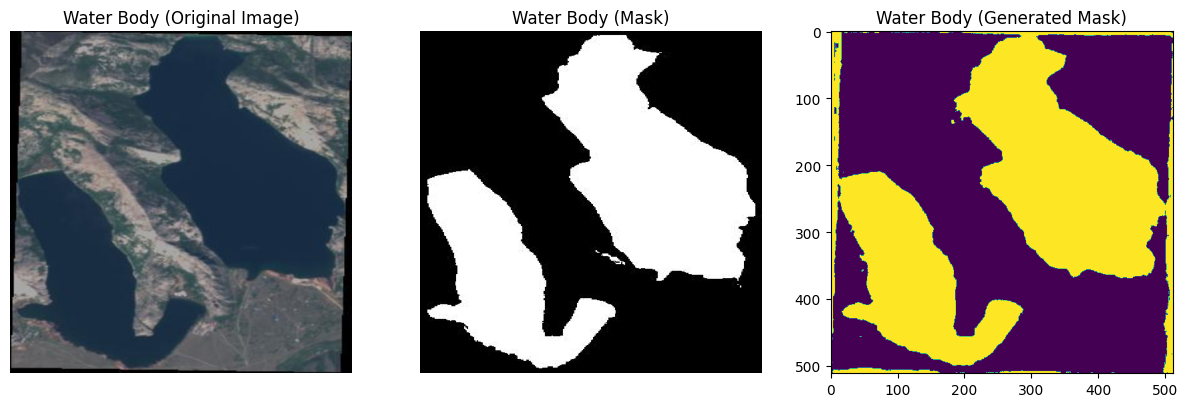

Training Losses -> Dice: 0.22372, BCE: 0.30262
Validation Losses -> Dice: 0.23131, BCE: 0.29295
Model improved and saved to /Users/dhruval/Desktop/GeoAI/WATER/modelPerformance/resnet50/model_0.23131dice.pt

Epoch 5/5


 62%|██████▏   | 88/142 [2:41:36<1:39:10, 110.19s/it]


KeyboardInterrupt: 

In [17]:
from tqdm import tqdm  # Import tqdm for progress bars

# Initialize variables for tracking best losses
best_val_dice_loss = np.Inf
best_val_bce_loss = np.Inf

# Define paths for saving models
performance_dir = "/Users/dhruval/Desktop/GeoAI/WATER/modelPerformance"
encoder_dir = os.path.join(performance_dir, ENCODER)  # Replace ENCODER_NAME
os.makedirs(performance_dir, exist_ok=True)
os.makedirs(encoder_dir, exist_ok=True)

# Training loop
EPOCHS = 5
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Wrap your training loader with tqdm for a progress bar
    train_loader_tqdm = tqdm(train_loader, desc="Training", unit="batch")
    train_dice_loss, train_bce_loss = train_segmentation_model(train_loader_tqdm, model, optimizer)
    
    # Wrap your validation loader with tqdm for a progress bar
    val_loader_tqdm = tqdm(val_loader, desc="Validation", unit="batch")
    val_dice_loss, val_bce_loss = evaluate_segmentation_model(val_loader_tqdm, model)

    print(f"Training Losses -> Dice: {train_dice_loss:.5f}, BCE: {train_bce_loss:.5f}")
    print(f"Validation Losses -> Dice: {val_dice_loss:.5f}, BCE: {val_bce_loss:.5f}")

    if val_dice_loss < best_val_dice_loss:
        model_save_path = os.path.join(encoder_dir, f"model_{val_dice_loss:.5f}dice.pt")
        torch.save(model.state_dict(), model_save_path)
        print(f"Model improved and saved to {model_save_path}")

        best_val_dice_loss = val_dice_loss
        best_val_bce_loss = val_bce_loss


In [24]:
model.load_state_dict(torch.load("/Users/dhruval/Desktop/GeoAI/WATER/modelPerformance/resnet50/model_0.28431dice.pt"))

<All keys matched successfully>

In [25]:
model.eval()


SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

In [27]:
for i in range(0, 15):
    image, mask = next(iter(val_loader))
    image = image[i]
    mask = mask[i]
    
    predicted_mask = model(image.to('cuda', dtype = torch.float32).unsqueeze(0))
    predicted_mask = torch.sigmoid(predicted_mask)
    predicted_mask = (predicted_mask > RATIO) * 1.0

    image = np.transpose(image, (1, 2, 0))
    mask = mask.squeeze(0)
    predicted_mask = np.transpose(predicted_mask.detach().cpu().squeeze(0), (1, 2, 0))

    plt.figure(figsize = (15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Water Body (Original Image)")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap = 'gray')
    plt.title("Water Body (Mask)")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title("Water Body (Generated Mask)")
    plt.show()

AssertionError: Torch not compiled with CUDA enabled